# Damage-plasticity model with generic time stepping
This notebook is a work in progress on an abstract and general implementation of time integration algorithm for general damage-plasticity modes. It serves for the development of a package that can be configured by specifying the ingredients of thermodynamically based model

 - Vector of state variables $\boldsymbol{\mathcal{E}}$
 - Vector of thermodynamic streses $\boldsymbol{\mathcal{S}}$
 - Helmholtz free energy $\rho \psi(\boldsymbol{\mathcal{S}})$
 - Threshold on thermodynamical forces  $f(\boldsymbol{\mathcal{S}},\boldsymbol{\mathcal{E}})$ / Yield condition
 - Flow potential $\varphi(\boldsymbol{\mathcal{S}},\boldsymbol{\mathcal{E}})$

as symbolic equations using the sympy package. The time-stepping algorithm gets generated automatically within the thermodynamically framework. The derived  evolution equations and return-mapping to the yield surface is performed using Newton-Raphson scheme.  

In [1]:
import sympy as sp
sp.init_printing()
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

## Material parameters

In [2]:
E_b = sp.Symbol('E_b', real=True, nonnegative=True)
gamma = sp.Symbol('gamma', real=True, nonnegative=True)
K = sp.Symbol('K', real=True)
S = sp.Symbol('S', real=True)
r = sp.Symbol('r', real=True)
c = sp.Symbol('c', real=True)
tau_bar = sp.Symbol(r'\bar{\tau}', real=True, nonnegative=True)

In [3]:
material_params = {
    E_b:1, gamma:0.2, K:0.1, S:0.005, r:0.001, c:1, 
    tau_bar:1, 
}

In [4]:
material_params = {
    E_b:1, 
    gamma: 0.6, 
    K:1, 
    S:0.6, 
    r:0.001, 
    c:1, 
    tau_bar:1, 
}

In [5]:
py_vars = ('E_b', 'gamma', 'K', 'S', 'r', 'c', 'tau_bar')
map_py2sp = {py_var : globals()[py_var] for py_var in py_vars}
sp_vars = tuple(map_py2sp[py_var] for py_var in py_vars)

## State variables

In [6]:
s = sp.Symbol('s', real=True)
omega = sp.Symbol('omega', real=True, nonnegative=True)
omega.is_nonnegative
s_pi = sp.Symbol(r's_pi', real=True)
alpha = sp.Symbol('alpha', real=True)
z = sp.Symbol('z', real=True)

In [7]:
Eps = sp.Matrix([s_pi, z, alpha, omega])

## Helmholtz potential

The starting point in the thermodynamical representation of a process is a potential function of time dependent state variables. To describe the evolution of the state correctly describing the energy dissipation of the system the gradient of the potential function with respect to the state variables provides the generalized forces. The forces are constrained to characterize specific material properties, e.g. strength, hardening.

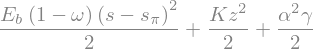

In [8]:
rho_psi = sp.Rational(1,2)* ( 
    (1-omega)*
    E_b*(s-s_pi)**2 + K * z**2 + gamma * alpha**2
)
rho_psi

## Thermodynamic forces

In [9]:
tau = sp.Symbol('tau', real=True)
tau_pi = sp.Symbol(r'tau_pi', real=True)
X = sp.Symbol('X', real=True)
Z = sp.Symbol('Z', real=True, nonnegative=True)
Y = sp.Symbol('Y', real=True)
Sig = sp.Matrix([tau_pi, Z, X, Y])

In [10]:
grad_rho_psi = sp.Matrix([rho_psi.diff(eps) for eps in Eps])

In [11]:
Sig_signs = sp.diag(1,-1,-1,1)

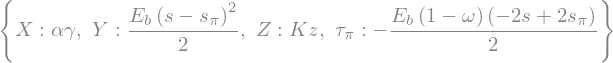

In [12]:
subs_Sigma = {
  var: val for var,val in zip(Sig, -Sig_signs*grad_rho_psi)
}
subs_Sigma

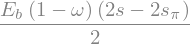

In [13]:
tau_ = rho_psi.diff(s)
tau_

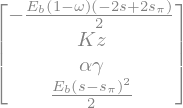

In [14]:
Sig_ = -Sig_signs * grad_rho_psi
Sig_

In [15]:
get_Sig = sp.lambdify(
    (s, Eps) + sp_vars, Sig_.T, 'numpy'
)

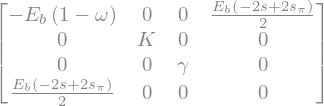

In [16]:
dSig_dEps_ = sp.Matrix([ 
    Sig_.T.diff(eps_i) for eps_i in Eps 
] ).T
dSig_dEps_

In [17]:
get_dSig_dEps = sp.lambdify(
    (s, Eps) + sp_vars, dSig_dEps_,
)

## Threshold function

Define effective stresses as a function of the apparent stress and damage.  Note that $\tau_\pi = \tau$.

In [18]:
tau_eff = sp.Function(r'\tau^{\mathrm{eff}}')(tau_pi, omega)
Q = sp.Function('Q')(tau_eff,X)
tau_eff

The stress norm is defined using the stress offset $X$, i.e. the kinematic hardening stress representing the shift of the origin of the yield locus.  

In [19]:
norm_Q = sp.sqrt(Q*Q)

General form of the yield condition then reads

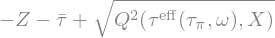

In [20]:
f = norm_Q - Z - tau_bar
f

In [21]:
subs_Q = {Q: tau_eff - X}
subs_Q

In [22]:
tau_pi, tau

In [23]:
subs_tau_eff = {tau_eff: tau_pi / (1-omega)}

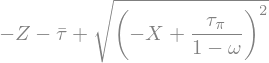

In [24]:
f_ = f.subs(subs_Q).subs(subs_tau_eff)
f_

In [25]:
get_f = sp.lambdify(
    (Eps, Sig) + sp_vars, f_, 'numpy'
)

In [26]:
df_dSig_ = f_.diff(Sig)
get_df_dSig = sp.lambdify(
    (Eps, Sig) + sp_vars, df_dSig_, 'numpy'
)

In [27]:
ddf_dEps_ = f_.diff(Eps)
get_ddf_dEps = sp.lambdify(
    (Eps, Sig) + sp_vars, ddf_dEps_, 'numpy'
)

## Flow potential

**Question:** If the flow potential is extended additively, it might be possible to reflect it in the iterative scheme to avoid repeated calculation of terms shared for derivatives and $f$ and of $\varphi$.

In [28]:
phi_ext = sp.Function('\phi')(Y,omega)

In [29]:
phi_ext_ = S * (1-omega)**c / (r+1) * (Y/S)**(r+1)

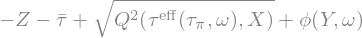

In [30]:
phi = f + phi_ext
phi

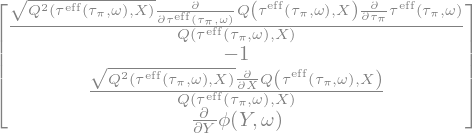

In [31]:
dphi_dSig_ = phi.diff(Sig)
dphi_dSig_

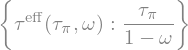

In [32]:
subs_tau_eff

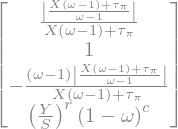

In [37]:
Phi_ = Sig_signs * dphi_dSig_.subs(subs_Q).subs(subs_tau_eff).subs(phi_ext,phi_ext_).doit()
sp.simplify(Phi_)

In [38]:
get_Phi = sp.lambdify(
    (Eps, Sig) + sp_vars, Phi_, 'numpy'
)

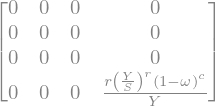

In [39]:
dPhi_dSig_ = sp.Matrix([ 
    Phi_.T.diff(sig_i) 
    for sig_i in Sig 
] ).T
sp.simplify(dPhi_dSig_)

In [40]:
get_dPhi_dSig = sp.lambdify(
    (Eps, Sig) + sp_vars, sp.simplify(dPhi_dSig_), 'numpy'
)

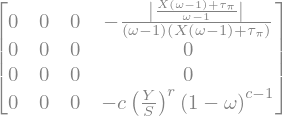

In [41]:
ddPhi_dEps_ = sp.Matrix([ 
    Phi_.T.diff(eta_i) 
    for eta_i in Eps 
] ).T
sp.simplify(ddPhi_dEps_)

In [42]:
get_ddPhi_dEps = sp.lambdify(
    (Eps, Sig) + sp_vars, sp.simplify(ddPhi_dEps_), 'numpy'
)

\begin{align}
\boldsymbol{\Phi} = - \boldsymbol{\Upsilon} \frac{\partial \varphi}{\partial \boldsymbol{\mathcal{S}}}
\end{align}

\begin{align}
f(\boldsymbol{\mathcal{E}}_{n+1};  \lambda) &= 0 \\
\boldsymbol{\mathcal{E}}_{n+1} &= 
\boldsymbol{\mathcal{E}}_{n} + \lambda \, \boldsymbol{\Phi}_{n+1}
\label{eq:discrete_evolution}
\end{align}

# Time integration scheme

Let us consider an inadmissible trial state $k$ and express the evolution equations and threshold functions both in implicit form

\begin{align}
f(\boldsymbol{\mathcal{E}}_{k}; \lambda_k ) & = 0 \\
\boldsymbol{\mathcal{F}}(\boldsymbol{\mathcal{E}}_{k}; \lambda_k ) &= 
\boldsymbol{\mathcal{E}}_{k} - \boldsymbol{\mathcal{E}}_{n} - \lambda_k \, \boldsymbol{\Phi}_{k} = 0
\end{align}

The evolution equations can be expanded using the Taylor series to obtain the approximation at an intermediate state of iteration $k$
\begin{align}
f_{k+1}
& =
f_{k} 
+
\left.
\frac{\partial f}{\partial \lambda}
\right|_k
\Delta \lambda +
\left.
\frac{\partial f}{\partial \boldsymbol{\mathcal{E}}}
\right|_k
\Delta \boldsymbol{\mathcal{E}} 
\\
\boldsymbol{\mathcal{F}}_{k+1}
& =
\boldsymbol{\mathcal{F}}_{k} 
+
\left.
\frac{\partial \boldsymbol{\mathcal{F}}}{\partial \lambda}  
\right|_k
\Delta \lambda +
\left.
\frac{\partial \boldsymbol{\mathcal{F}}}{\partial{\boldsymbol{ \mathcal{E}}}}  
\right|_k 
\Delta {\boldsymbol{\mathcal{E}}}
\end{align}

To reach an admissible state let us linearize the threshold function at an interim state $j$ as
\begin{align}
\left.
\frac{\partial f}{\partial{\boldsymbol{ \mathcal{E}}}}  
\right|_k 
&=
\left. \frac{\partial f}{ \partial \boldsymbol{\mathcal{S}}}\right|_{k}
\left. \frac{\partial \boldsymbol{\mathcal{S}}}{\partial \boldsymbol{\mathcal{E}}}\right|_{k}
+
\left. \frac{\partial^{\mathrm{dir}} f}{ \partial^{\mathrm{dir}} \boldsymbol{\mathcal{E}}}\right|_{k}
\label{eq:df_dEps}
\\
\left.
\frac{\partial f}{\partial{\lambda}}  
\right|_k 
&=
\left.
\frac{\partial f}{\partial{\boldsymbol{ \mathcal{E}}}}  
\right|_k 
\left.
\frac{\partial {\boldsymbol{ \mathcal{E}}}}{\partial \lambda}
\right|_k =
\left.
\frac{\partial f}{\partial{\boldsymbol{ \mathcal{E}}}}  
\right|_k 
\boldsymbol{\Phi}_k 
\label{eq:df_dlambda}
\\
\left.
\frac{\partial \boldsymbol{\mathcal{F}}}{\partial{\boldsymbol{ \mathcal{E}}}}  
\right|_k 
&=
I - \lambda_{k} \left. \frac{\partial \boldsymbol{\Phi}}{\partial \boldsymbol{\mathcal{E}}}\right|_{k}
\label{eq:dF_dEps}
\\
\left.
\frac{\partial \boldsymbol{\mathcal{F}}}{\partial{\lambda}}  
\right|_k 
&= -\boldsymbol{\Phi}_{k}
\label{eq:dF_dlambda}
\end{align}

**Remark 3:** The derivative $\partial^\mathrm{dir}$ denotes the direct derivative

**Remark 2:** Note that $\displaystyle \frac{\partial \boldsymbol{\mathcal{E}}}{\partial \lambda}$ in equation $\eqref{eq:df_dlambda}$ can be obtained from the evolution equations $\eqref{eq:discrete_evolution}$
\begin{align}
\boldsymbol{\mathcal{E}}_k = \boldsymbol{\mathcal{E}}_n + \lambda \, \boldsymbol{\Phi}_k\; \implies
\left.
\frac{\partial {\boldsymbol{ \mathcal{E}}}}{\partial \lambda}
\right|_k = 
\boldsymbol{\Phi}_k
\end{align}

**Remark 3:** The derivative of the compass with respect to the kinematic state variables in equation $\eqref{eq:dF_dEps}$ can be resolved to
\begin{align}
\left. \frac{\partial \boldsymbol{\Phi}}{\partial \boldsymbol{\mathcal{E}}} \right|_k 
&=
\left. \frac{\partial \boldsymbol{\Phi}}{\partial \boldsymbol{\mathcal{S}}} \right|_k 
\left. \frac{\partial \boldsymbol{\mathcal{S}}}{\partial \boldsymbol{\mathcal{E}}} \right|_k 
+
\left. \frac{\partial^\mathrm{dir} \boldsymbol{\Phi}}{\partial^\mathrm{dir} \boldsymbol{\mathcal{E}}} \right|_k 
\end{align}

we can assemble a system of recurrent equations as follows
\begin{align}
& \left[
\begin{array}{cc}
\displaystyle
\left.
\frac{\partial f}{\partial{\lambda}}  
\right|_k 
&
\displaystyle
\left.
\frac{\partial f}{\partial{\boldsymbol{ \mathcal{E}}}}  
\right|_k 
\\
\displaystyle
\left.
\frac{\partial \boldsymbol{\mathcal{F}}}{\partial{\lambda}}  
\right|_k 
&
\displaystyle
\left.
\frac{\partial \boldsymbol{\mathcal{F}}}{\partial{\boldsymbol{ \mathcal{E}}}}  
\right|_k 
\end{array}
\right]
\left[
\begin{array}{c}
\Delta \lambda
\\
\Delta {\boldsymbol{\mathcal{E}}}
\end{array}
\right] =
 - \left[
\begin{array}{c}
f_k \\
\boldsymbol{\mathcal{F}}_k 
\end{array}
\right] \\
& \lambda_{k+1} = \lambda_{k} + \Delta \lambda \\
& \boldsymbol{\mathcal{E}}_{k+1} = 
\boldsymbol{\mathcal{E}}_{k} + \Delta \boldsymbol{\mathcal{E}} \\
&k = k + 1
\end{align}

Let's try to assemble the Jacobian from the ingredients of the material model 

## Implementation concept
The gradient operators needed for the time-stepping scheme have been derived above and are now available for the implementation of the numerical algorithm both in `Python` and `C89` languages

<table style="width:50%">
<tr>
<th>Symbol</th>
<th>Python</th>
<th>C89</th>
</tr>
<tr>
<td>$\mathcal{S}(\boldsymbol{\varepsilon}, \boldsymbol{\mathcal{E}}) $  
</td>
<td>get_Sig</td>
<td>get_Sig_C</td>
</tr>
<tr>
<td>
    $\displaystyle\frac{\partial \boldsymbol{\mathcal{S}}}{\partial \boldsymbol{\mathcal{E}}}
    (\boldsymbol{\boldsymbol{\varepsilon}, \mathcal{E}}) $</td>
<td>get_dSig_dEps</td>
<td>get_dSig_dEps_C</td>
</tr>
<tr>
<td>$ f(\boldsymbol{\mathcal{S}}, \boldsymbol{\mathcal{E}})$</td>
<td>get_f</td>
<td>get_f_C</td>
</tr>
<tr>
<td>
    $\displaystyle\frac{\partial f}{\partial \boldsymbol{\mathcal{S}}}
    (\boldsymbol{\mathcal{S}},\boldsymbol{\mathcal{E}}) $
    </td>
<td>get_df_dSig</td>
<td>get_df_dSig_C</td>
</tr>
<tr>
<td>
$\displaystyle\frac{\partial^\mathrm{dir} f}{\partial^\mathrm{dir} \boldsymbol{\mathcal{E}}}
    (\boldsymbol{\mathcal{S}},\boldsymbol{\mathcal{E}}) $
<td>get_ddf_dEps</td>
<td>get_ddf_dEps_C</td>
</tr>
<tr>
<td>
    $\boldsymbol{\Phi}(\boldsymbol{\mathcal{S}}, \boldsymbol{\mathcal{E}}) $</td>
<td>get_Phi</td>
<td>get_Phi_C</td>
</tr>
<tr>
<td>$\displaystyle\frac{\partial \boldsymbol{\Phi}}{\partial \boldsymbol{\mathcal{S}}}(\boldsymbol{\mathcal{S}}, \boldsymbol{\mathcal{E}}) $</td>
<td>get_dPhi_dSig</td>
<td>get_dPhi_dSig_C</td>
</tr>
<tr>
<td>$\displaystyle\frac{\partial^\mathrm{dir} \boldsymbol{\Phi}}{\partial^\mathrm{dir} \boldsymbol{\mathcal{E}}}(\boldsymbol{\mathcal{S}}, \boldsymbol{\mathcal{E}}) $</td>
<td>get_ddPhi_dEps</td>
<td>get_ddPhi_dEps_C</td>
</tr>
</table>

In [53]:
def get_f_df_k(s_n1, Eps_n, lam_k, Eps_k, *margs):
    # Generalized stresses
    Sig_k = get_Sig(s_n1, Eps_k, *margs)[0]
    dSig_dEps_k = get_dSig_dEps(s_n1, Eps_k, *margs)
    # Threshold value
    f_k = np.array([get_f(Eps_k, Sig_k, *margs)])
    #print('f_k', f_k)
    df_dSig_k = get_df_dSig(Eps_k, Sig_k, *margs)
    ddf_dEps_k = get_ddf_dEps(Eps_k, Sig_k, *margs)
    df_dEps_k = np.einsum('ik,ij->kj', df_dSig_k, dSig_dEps_k) + ddf_dEps_k.T
    # Flow potential
    Phi_k = get_Phi(Eps_k, Sig_k, *margs)
    print('Eps_k', Eps_k, 'Sig_k', Sig_k)
    print(*margs)
    print('Phi_k', Phi_k)
    F_k = Eps_k[:,None] - Eps_n[:,None] - lam_k * Phi_k
    dPhi_dSig_k = get_dPhi_dSig(Eps_k, Sig_k, *margs)
    ddPhi_dEps_k = get_ddPhi_dEps(Eps_k, Sig_k, *margs)
    dPhi_dEps_k = np.einsum('ik,kj->ij', dPhi_dSig_k, dSig_dEps_k) + ddPhi_dEps_k
    # Predictor matrix
    df_dlambda_k = np.einsum('ik,kj->ij', df_dEps_k, Phi_k)
    dF_dEps_k = np.identity(len(Eps)) - lam_k * dPhi_dEps_k
    dF_dlambda_k = -Phi_k
    # Residuum value and derivative
    R_k = np.block([[f_k],
                    [F_k]])
    dR_k = np.block([[df_dlambda_k, df_dEps_k],
                     [dF_dlambda_k, dF_dEps_k]])
    if False:
        print('Sig_k', Sig_k)
        print('dSig_dEps_k', dSig_dEps_k)
        print('f_k', f_k)
        print('df_dSig_k', df_dSig_k)
        print('ddf_dEps_k', ddf_dEps_k)
        print('df_dEps_k', df_dEps_k)
        print('Phi_k', Phi_k)
        print('dPhi_dSig_k', dPhi_dSig_k)
        print('ddPhi_dEps_k', ddPhi_dEps_k)
        print('dPhi_dEps_k', dPhi_dEps_k)
        print('df_dlambda_k', df_dlambda_k)
        print('dF_dEps_k', dF_dEps_k)
        print('dF_dlambda_k', dF_dlambda_k)
    return R_k, dR_k, Sig_k

In [54]:
margs = [material_params[map_py2sp[name]] for name in py_vars]
margs

In [55]:
if True: # debugging get_f_df_k
    Eps_n = np.zeros((len(Eps),), dtype=np.float_)
    get_f_df_k(3, Eps_n, 0, Eps_n+0.4, *margs)

Eps_k [0.4 0.4 0.4 0.4] Sig_k [1.56 0.4  0.24 3.38]
1 0.6 1 0.6 0.001 1 1
Phi_k [[1.66666667]
 [1.        ]
 [1.        ]
 [0.60103812]]


In [58]:
def get_response(margs, s_max=1.3, n_steps = 10, k_max=20, get_load_fn=lambda t: t):
    Eps_n = np.zeros((len(Eps),), dtype=np.float_)
    Eps_k = np.copy(Eps_n)
    Sig_record = []
    Eps_record = []
    iter_record = []
    t_arr = np.linspace(0,1,n_steps+1)
    s_t = s_max * get_load_fn(t_arr)
    for s_n1 in s_t:
        print('s_n1', s_n1)
        lam_k = 0
        f_k, df_k, Sig_k = get_f_df_k(s_n1, Eps_n, lam_k, Eps_k, *margs)
        f_k_norm = np.linalg.norm(f_k)
        f_k_trial = f_k[0]
        k = 0
        while k < k_max:
            print('R_k', f_k, f_k_norm)
            if f_k_trial < 0 or f_k_norm < 1e-3:
                Eps_n[...] = Eps_k[...]
                Sig_record.append(Sig_k)
                Eps_record.append(np.copy(Eps_k))
                iter_record.append(k+1)
                break
            print('dR_k', df_k)
            dU = np.linalg.solve(df_k, -f_k)
            print('U_k', dU)
            #np.nan_to_num(U, copy=False)
            lam_k += dU[0,0]
            Eps_k += dU[1:,0]
            f_k, df_k, Sig_k = get_f_df_k(s_n1, Eps_n, lam_k, Eps_k, *margs)
            f_k_norm = np.linalg.norm(f_k)
            k += 1
        else:
            print('no convergence')
    Sig_arr = np.array(Sig_record, dtype=np.float_)
    Eps_arr = np.array(Eps_record, dtype=np.float_)
    iter_arr = np.array(iter_record,dtype=np.int_)
    return t_arr, s_t, Eps_arr, Sig_arr, iter_arr

In [60]:
t_arr, s_t, Eps_arr, Sigma_arr, iter_arr = get_response(
    margs=margs, s_max=1.1, n_steps=1, k_max=10
)

s_n1 0.0
Eps_k [0. 0. 0. 0.] Sig_k [-0.  0.  0.  0.]
1 0.6 1 0.6 0.001 1 1
Phi_k [[nan]
 [ 1.]
 [nan]
 [nan]]
R_k [[-1.]
 [nan]
 [ 0.]
 [nan]
 [nan]] nan
s_n1 1.1
Eps_k [0. 0. 0. 0.] Sig_k [1.1   0.    0.    0.605]
1 0.6 1 0.6 0.001 1 1
Phi_k [[1.       ]
 [1.       ]
 [1.       ]
 [1.0000083]]
R_k [[0.1]
 [0. ]
 [0. ]
 [0. ]
 [0. ]] 0.10000000000000009
dR_k [[-2.6       -1.        -1.        -0.6        0.       ]
 [-1.         1.         0.         0.         0.       ]
 [-1.         0.         1.         0.         0.       ]
 [-1.         0.         0.         1.         0.       ]
 [-1.0000083  0.         0.         0.         1.       ]]
U_k [[0.01923077]
 [0.01923077]
 [0.01923077]
 [0.01923077]
 [0.01923093]]
Eps_k [0.01923077 0.01923077 0.01923077 0.01923093] Sig_k [1.05998503 0.01923077 0.01153846 0.58403107]
1 0.6 1 0.6 0.001 1 1
Phi_k [[1.01960801]
 [1.        ]
 [1.        ]
 [0.98074261]]
R_k [[ 5.00000000e-02]
 [-3.77077097e-04]
 [ 3.46944695e-18]
 [ 0.00000000e+00]
 [ 3

s_n1 1e-09
Eps_k [0. 0. 0. 0.] Sig_k [1.e-09 0.e+00 0.e+00 5.e-19]
1 0.6 1 0.6 0.001 1 1
Phi_k [[1.        ]
 [1.        ]
 [1.        ]
 [0.95922573]]
s_n1 1.1000000010000002
Eps_k [0. 0. 0. 0.] Sig_k [1.1   0.    0.    0.605]
1 0.6 1 0.6 0.001 1 1
Phi_k [[1.       ]
 [1.       ]
 [1.       ]
 [1.0000083]]
R_k [[0.1]
 [0. ]
 [0. ]
 [0. ]
 [0. ]]
dR_k [[-2.6       -0.        -0.        -0.         0.       ]
 [-1.         1.         0.         0.         0.       ]
 [-1.         0.         1.         0.         0.       ]
 [-1.         0.         0.         1.         0.       ]
 [-1.0000083  0.         0.         0.         1.       ]]
U_k [[0.03846154]
 [0.03846154]
 [0.03846154]
 [0.03846154]
 [0.03846186]]
Eps_k [0.03846154 0.03846154 0.03846154 0.03846186] Sig_k [1.02070972 0.03846154 0.02307692 0.56343195]
1 0.6 1 0.6 0.001 1 1
Phi_k [[1.04000035]
 [1.        ]
 [1.        ]
 [0.96147768]]
no convergence


ValueError: x and y must have same first dimension, but have shapes (2,) and (1,)

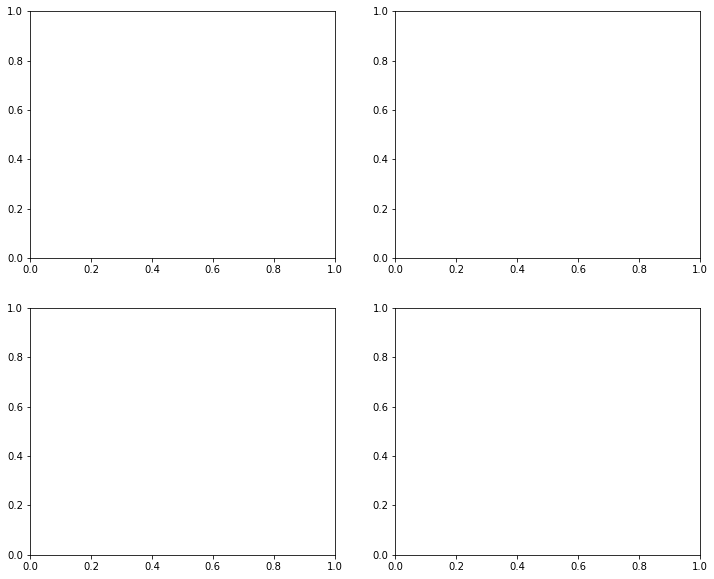

In [364]:
t_arr, s_t, Eps_arr, Sigma_arr, iter_arr = get_response(
    margs=margs, s_max=1.1, n_steps=1, k_max=1
)
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(12, 10))
colors = ['blue','red', 'green', 'black', 'magenta' ]
ax1.plot(s_t, Sigma_arr[:,0], color='red');
ax2.plot(t_arr, iter_arr, color='green');

In [69]:
def plot_Sigma_Eta(Sigma, Eta):
    fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(10,6))
    colors = ['blue','red', 'green', 'black', 'magenta' ]
    s_pi_, z_, alpha_, omega_ = Eta_arr.T
    sig_pi_, Z_, X_, Y_ = Sigma_arr.T
    ax1.plot(s_t, sig_pi_, color='black', 
             label='n_steps = %g' % n_step)
    ax1.set_xlabel('$s$'); ax1.set_ylabel(r'$\tau$')
    ax1.legend()
    ax11 = ax1.twinx()
    ax11.plot(s_t, iter_arr, '-.')
    ax2.plot(t_arr, omega_, color='red', 
             label='n_steps = %g' % n_step)
    ax2.set_xlabel('$s$'); ax2.set_ylabel(r'$\omega$')
    ax22 = ax2.twinx()
    ax22.plot(t_arr, Y_, '-.', color='red', 
             label='n_steps = %g' % n_step)
    ax22.set_ylabel('$Y$')
    ax3.plot(t_arr, z_, color='green', 
             label='n_steps = %g' % n_step)
    ax3.set_xlabel('$s$'); ax3.set_ylabel(r'$z$')
    ax33 = ax3.twinx()
    ax33.plot(t_arr, Z_, '-.', color='green')
    ax33.set_ylabel(r'$Z$')
    ax4.plot(t_arr, alpha_, color='blue', 
             label='n_steps = %g' % n_step)
    ax4.set_xlabel('$s$'); ax4.set_ylabel(r'$Z$')
    ax44 = ax4.twinx()
    ax44.plot(t_arr, X_, '-.', color='blue')
    plt.show()

## Load history

In [ ]:
t = sp.symbols('t')
load_fn = sp.Piecewise(
    (2*t, t < 0.5),
    (1-2*(t-0.5), t < 0.75),
    (0.5+2*(t-0.75), t < 1),
    (1-2*(t-1), t < 1.25),
    (0.5+2*(t-1.25), t >= 1.25)
)
get_load_fn = sp.lambdify(
    t, load_fn
)
t_arr = np.linspace(0,1.5,100)
s_t = get_load_fn( np.linspace(1e-9,1.5,100))
plt.plot( t_arr, s_t);

In [ ]:
t_arr, s_t, Eta_arr, Sigma_arr, iter_arr = get_response(
    n_steps=100, get_load_fn=get_load_fn)
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(12, 10))
colors = ['blue','red', 'green', 'black', 'magenta' ]
ax1.plot(s_t, Sigma_arr[:,0], color='red');
ax2.plot(t_arr, iter_arr, color='green');